# Drifter dispersion analysis using the ldrift package 

In [1]:
####################
#lib imports   #####
####################

# NOTE: That some packages may be redundant or not used, but have been kept for future additions

# Data manipulation
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
#from numba import njit

#ANALysis
from scipy import stats
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import linregress
from scipy.stats import t
from scipy.spatial import cKDTree
from scipy.stats import bootstrap
import piecewise_regression as piecewise_regression
from pwlf import PiecewiseLinFit

# GIS and such
from geopy import distance
import geopy as gp
from shapely.geometry import Point
from shapely.geometry import Polygon


# Others
from itertools import combinations
from tqdm import tqdm
from collections import Counter
import time
import math
import os
import io
from datetime import datetime
import glob

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import seaborn as sns
import cmocean
import colormaps as cmaps
import matplotlib.animation as animation # For animations
from PIL import Image # For animations


In [2]:
## IMPORT LDRIFT FUNCS ##

from ldrift import drift_funcs as ld
#from ldrift import triad_funcs as tf
from ldrift import get_drifter_data
from ldrift.preproc import create_ragged_arr


# Openning Datasets
First, we will open drifter datasets as ragged contiguous arrays using xarray to open netcdf files. A few different datasets are here to choose from based on the ones that I subset. The main dataset is the GDP v2.00 dataset, which contains the global hourly data from all SVP drifters released between 1979 and 2020. The main dataset used is a subset of the GDP for the EAC region, which includes 313 drifter trajectories. Optionally, you can also open already processed data here to speed up the remaining calculations in this notebook (for demonstration we will go through all steps using the GDP v2.0 ds).

In [3]:
# GDP FILES - REAL DRIFTERS #
file_GDP = 'gdp_v2.00.nc'
#file_EAC = 'EAC_drifters_disp.nc' # For EAC subset

path = 'C:/Users/z5493451/OneDrive - UNSW/Documents/Data/Drifters/' # Where data lives
fig_path = 'C:/Users/z5493451/OneDrive - UNSW/Documents/Ooni/UNSW/PhD/Figures/' # Where figures exist

fileloc_GDP = path+file_GDP
#fileloc_EAC = path+file_EAC

ds = xr.open_dataset(fileloc_GDP, decode_times=True)
#ds = ld.retrieve_region(ds_gdp, not_ids=[139659]) # Remove eroneous traj

#ds = xr.open_dataset(fileloc_EAC, decode_times=True)
#ds = ld.retrieve_region(ds, not_ids=[139659, 300234062721340, 300234063430970])

# GLOBAL COLOuR MAP #
# Used to keep colours the same across plots
glob_cmap, glob_norm = ld.traj_cmap(ds.traj.values, random_seed=42)

# Encoding for if datasets need to be saved later
ds_encoding = {'DeploymentComments': {'dtype': 'str'}}

ds

<xarray.Dataset>
Dimensions:                (traj: 310, obs: 1498507, color: 4)
Coordinates:
    ID                     (traj) int64 101528 101536 101749 ... 95853 9918857
    longitude              (obs) float32 ...
    latitude               (obs) float32 ...
    time                   (obs) datetime64[ns] 2013-03-16T06:00:00 ... 2000-...
    ids                    (obs) int64 101528 101528 101528 ... 9918857 9918857
  * obs                    (obs) int64 0 1 2 3 ... 1527467 1527468 1527469
Dimensions without coordinates: traj, color
Data variables: (12/61)
    rowsize                (traj) int32 9648 4424 6566 2881 ... 2839 2783 7711
    location_type          (traj) bool ...
    WMO                    (traj) int32 ...
    expno                  (traj) int32 ...
    deploy_date            (traj) datetime64[ns] ...
    deploy_lon             (traj) float32 ...
    ...                     ...
    displacement           (obs) float64 ...
    A2                     (obs) float64 ...
    disp_x                 (obs) float64 ...
    disp_y                 (obs) float64 ...
    disp_x2                (obs) float64 ...
    disp_y2                (obs) float64 ...
Attributes: (12/15)
    title:             Global Drifter Program hourly drifting buoy collection
    history:           Version 2.00.  Metadata from dirall.dat and deplog.dat
    Conventions:       CF-1.6
    date_created:      2022-01-14T11:16:01.998226
    publisher_name:    GDP Drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    ...                ...
    metadata_link:     https://www.aoml.noaa.gov/phod/dac/dirall.html
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    institution:       NOAA Atlantic Oceanographic and Meteorological Laboratory
    acknowledgement:   Elipot et al. (2022) to be submitted. Elipot et al. (2...
    summary:           Global Drifter Program hourly data

# Chunking with Dask (Optional)
The bellow section plays around with chunks. Chunks set the data into 'array-like' objects that can be processed through functions using the apply_ufunc call in xarray. This may come in useful when doing things such as wavelet ridge analysis on multiple trajectories (a similar opperation is shown using a periodogram method in the GDP introductory analysis notebook at https://github.com/Cloud-Drift/earthcube-meeting-2022/tree/main). For simplicity, we do not use dask in this example notebook (all functions work without dask).

In [ ]:
#Set chunk sizes to align with rowsizes
rowsize = ds.rowsize.values
ds.close()  # close ds so that we can open it again with aligned chunk sizes
# align chunks with the length of each individual trajectory
chunk_settings = {'obs': tuple(rowsize.tolist())}
ds = xr.open_dataset(fileloc_GDP, decode_times=True, chunks=chunk_settings)
ds

# Example plots using the 'driftplot' function
The driftplot function is made to make ploting drifters easier, by having simple inputs to control which variables are plotted, whether starting points and drifter ID labels should be shown, and what domain should be plotted. It also has an option to show or hide land boundaries.

The driftplot function will be improved in future; I would like to add the option to plot other features below the trajectories and also make animations and multiplots!

In [ ]:
# PLOT ALL THE DRIFTERS IN THE GDP DATASET#
all_GDP_plot = ld.driftplot(ds, domain=[-180,180,-60,60], set_dpi=720)

In [ ]:
drift_p_time = ld.driftplot(ds=ds,time=True)

In [ ]:
# PLOT VELOCITIES
domain = (145,165,-45,-20) # Choose domain

drift_p_u  = ld.driftplot(ds, veast=True, labs=False, domain=domain, traj_cmap=glob_cmap, traj_norm=glob_norm, set_dpi=150)
drift_p_v  = ld.driftplot(ds, vnorth=True, labs=False, domain=domain, traj_cmap=glob_cmap, traj_norm=glob_norm, set_dpi=150)

# Creating animations using the 'drift_animation' function
Create trajectory animations by setting an extent (animation_domain) and providing a frame directory and output directory. The animation is created from a series of images 'frames' in a file - make sure you empty the file before generating the animation. NOTE: I do not reconmend running this with the entire GDP dataset, first subset a smaller number of drifters (see 'Subset the GDP dataset').

In [11]:
# Create animation frames
animation_domain  = (150,156,-31,-36)
framedir = 'C:/Users/z5493451/OneDrive - UNSW/Documents/Data/Drifters/animations'
outputdir = 'C:/Users/z5493451/OneDrive - UNSW/Documents/Data/Drifters/animations_full/temp.gif'
ld.drift_frames(ds=ds, IBM=None, plot_int=1, duration=60, labs=['SVP'], domain=animation_domain, framedir=framedir, traj_cmap=glob_cmap, traj_norm=glob_norm)

# Create animation from frames
ld.drift_animation(framedir, outputdir)

Animation created from frames.


# Subseting the GDP dataset
Probably the most useful function in the ldrift library is the 'retrieve_region' function. When called retrieve_region will return a subset of the supplied dataset based on a number of parameters set by the user (these range from spatial and temporal boundaries and ID specific or limiting conditions, and muuch more - see the full function docstring). The subset can then be saved for later use, or used temporarilly in other functions.

In [ ]:
# SUBSETTING BASED ON DROGUE PRESENCE
ds_drogued, ds_undrogued = ld.drogue_subset(ds)

# Reseting traj cols and plotting
ds_drogued = ld.get_traj_cols(ds_drogued)
ds_undrogued = ld.get_traj_cols(ds_undrogued)


ld.driftplot(ds_drogued, traj_cmap=glob_cmap, traj_norm=glob_norm)
ld.driftplot(ds_undrogued, traj_cmap=glob_cmap, traj_norm=glob_norm)

print('Number of drogued trajectories: ', len(ds_drogued.ID.values))
print('Number of undrogued trajectories: ', len(ds_undrogued.ID.values))

# Optionally, save them for later
#ds_drogue.to_netcdf(path+'all_drogue.nc', mode='w')
#ds_undrogue.to_netcdf(path+'all_undrogue.nc', mode='w')

In [ ]:
# SUBSET THE EAST AUSTRALIAN CURRENT (EAC) REGION, AND THEN #
# SEPERATE IT INTO DROGUED AND UNDROGUED OBSERVATIONS       #

lon = [145, 165]
lat = [-45, -20]

ds_EAC = ld.retrieve_region(ds, lat=lat, lon=lon, full=False, debug=False)
ds_EAC_drogued, ds_EAC_undrogued = ld.drogue_subset(ds_EAC)

print('Number of drogued trajectories: ', len(ds_EAC_drogued.ID.values))
print('Number of undrogued trajectories: ', len(ds_EAC_undrogued.ID.values))
ds_EAC_drogued

In [ ]:
# CREATE NORTH EAC AND SOUTH EAC SUBSETS #
ds_north = ld.retrieve_region(ds.drop_vars(['disp_x','disp_y','displacement','A2','disp_x2','disp_y2']),
                              lat=[-33,-25], lon=[145, 155], full=False, not_ids=[139659, 300234062721340, 300234063430970])

ds_south = ld.retrieve_region(ds.drop_vars(['disp_x','disp_y','displacement','A2','disp_x2','disp_y2']),
                              lat=[-40,-33], lon=[145, 155], full=False, not_ids=[139659, 300234062721340, 300234063430970])

ds_north_drogued, ds_north_undrogued = ld.drogue_subset(ds_north)
ds_south_drogued, ds_south_undrogued = ld.drogue_subset(ds_south)


# SEGMENT THE NORTH AND SOUTH SUBSETS USING A 10 DAY CUT LENGTH #
cut_length = 10

ds_north_drogued = ld.segments(ds_north_drogued, tl=cut_length)
ds_south_drogued = ld.segments(ds_south_drogued, tl=cut_length)

ds_north_undrogued = ld.segments(ds_north_undrogued, tl=cut_length)
ds_south_undrogued = ld.segments(ds_south_undrogued, tl=cut_length)

ds_north_all = ld.segments(ds_north, tl=cut_length)
ds_south_all = ld.segments(ds_south, tl=cut_length)


In [ ]:
# ALTERNATIVELY WE CAN SUBSET USING A SHAPE FILE (HERE CONSTRUCTED WITH A LIST OF VERTICES) #
EKE_box = [(151.8, -33.1), (155.2, -33.8), (154.2, -36.6), (151, -35.9)] # Box of max Eddy kinetic energy in the EAC
#domain_box = [(150, -32.5), (156, -32.5), (156, -39.5), (150, -39.5)]

ds_EKEBOX = ld.retrieve_region(ds, vertices=EKE_box, full=False) # Using EKE box
EKE_cmap, EKE_norm = ld.traj_cmap(ds_south.traj.values)
southplot = ld.driftplot(ds_EKEBOX, labs=False, pinfo=False, traj_cmap=EKE_cmap, traj_norm=EKE_norm)


In [ ]:
# SUBSET THE DROGUE AND UNDROGUE OBSERVATIONS FOR THE SEASONAL ANALYSIS

summer = [1,2,3,11,12] #Dec - Mar
winter = [5,6,7,8,9] #Jun - Sep

ds_winter_tmp = ld.retrieve_region(ds=ds_EAC, month_range=winter, dt_range=[0, 300*24*3600], full=False)
ds_summer_tmp = ld.retrieve_region(ds=ds_EAC, month_range=summer, dt_range=[0, 300*24*3600], full=False)
ds_winter_drogue, ds_winter_undrogue = ld.drogue_subset(ds=ds_winter_tmp)
ds_summer_drogue, ds_summer_undrogue = ld.drogue_subset(ds=ds_summer_tmp)

# SEGMENT AND CALCULATE DISPERSION (optional)
ds_winter_drogue = ld.segments(ds=ds_winter_drogue, Tl=10)
ds_summer_drogue = ld.segments(ds=ds_summer_drogue, Tl=10)
#ds_winter_drogue = ld.cohort_displace(ds=ds_winter_drogue, sub_mean=True, tau=20) # For dispersion analysis
#ds_summer_drogue = ld.cohort_displace(ds=ds_summer_drogue, sub_mean=True, tau=20) # For dispersion analysis
#ds_winter = ld.disp_tensor(ds=ds_winter_drogue, res=0.5)
#ds_summer = ld.disp_tensor(ds=ds_summer_drogue, res=0.5)

# SAVE FOR LATER (optional)
#ds_winter_drogue.to_netcdf(path+'winter_ds.nc')
#ds_summer_drogue.to_netcdf(path+'summer_ds.nc')

ld.driftplot(ds_winter_tmp)
ld.driftplot(ds_summer_tmp)

# Meta Data
Since the 'deploy_date' variable is not always accurate as a start position, we use a function to take the first time and positional values in the observational dimension instead ('deploy_date' is stored as a single value for each drifter in the traj dim). It is important to note that when retrieving a region, using full trajectories in the output can have consequences here, since start times will vary based on where trajs are cut off (this can be avoided by using different options - namely the full=False command - when subsetting). 

In [6]:
# Create a dataframe containing the first recorded location and time for every drifter in the given ds
drift_meta = ld.drift_meta(ds_EAC, op_type = 'df')

# Optionally, save to csv
#saveloc = path+'ds_meta.csv'  
#drift_meta.to_csv(saveloc,index=False)
drift_meta

,ID,WMO,start_lat,start_lon,start_time,end_time
0,300234063129200,5501533,-34.57196,152.480026,2017-09-13 02:00:00,2018-05-09
1,300234063129220,5501530,-34.813202,153.011993,2017-09-12 18:00:00,2018-05-10
2,300234063430970,5501528,-34.77277,153.180313,2017-09-12 17:00:00,2019-06-19
3,300234063434930,5501529,-34.698608,153.250107,2017-09-11 23:00:00,2021-02-25
4,300234063701990,5501531,-34.813,153.011002,2017-09-12 18:00:00,2019-02-18
5,300234064900820,5501537,-35.219002,151.890594,2017-09-14 00:00:00,2019-03-24
6,300234064905840,5501534,-35.076771,152.316895,2017-09-12 23:00:00,2021-04-26
7,300234064905860,5501535,-35.078499,152.315735,2017-09-12 23:00:00,2020-08-05
8,300234064907870,5501536,-35.234612,151.935287,2017-09-13 02:00:00,2020-02-01


In [54]:
# Calculate start distances between all drifters and then find pairs
start_dists = ld.start_sep(ds_EAC, op_type='triangular')
pairs = ld.find_pairs(ds_EAC, start_dists=start_dists)
pairs

,level_0,level_1,start_sep,start_dt,ID0,ID1
row_index,,,,,,
16443,58.0,59.0,1.455691,-1 days +23:00:00,139661,139662
16444,58.0,60.0,3.951145,0 days 00:00:00,139661,139663
16697,59.0,60.0,4.974199,0 days 01:00:00,139662,139663
28728,112.0,113.0,1.670433,-1 days +21:00:00,300234060953420,300234060953430
33082,135.0,143.0,0.093478,0 days 00:00:00,300234063129220,300234063701990
37802,164.0,165.0,0.218953,0 days 00:00:00,300234064905840,300234064905860
43473,209.0,211.0,4.401665,0 days 01:00:00,41882,42961
46748,248.0,249.0,4.385445,0 days 00:00:00,63138,63139
47059,253.0,255.0,4.008024,0 days 00:00:00,63143,63145


Plotting some meta-data:
The first plot is a time series showing the number of drifter OBSERVATIONS per year in the EAC dataset. This is different to the second plot,
that uses the 'drift_meta' function to find the 'start times' of all drifters that enter the EAC region and then plot a time series of these. The third, is similar to the second, however it considers ACTIVE drifters, by checking the end time in the meta dataframes.

In [ ]:
# Plotting side-by-side histograms
data1 = ld.retrieve_region(ds=ds_EAC_drogue, min_time='2000-01-01T00:00:00.000000000').time.values
data2 = ld.retrieve_region(ds=ds_EAC_undrogue, min_time='2000-01-01T00:00:00.000000000').time.values
xmin=np.datetime64('1998')
xmax=np.datetime64('2022')
hist_colors =[cmaps.WhBlReWh(44), cmaps.WhBlReWh(53)]

plt.figure(figsize=(6, 6))
plt.hist([data1, data2], bins=24, alpha=0.7, range=(xmin, xmax),
         label=['Drogued', 'Undrogued'], histtype='barstacked',
         color=hist_colors, edgecolor='black', align='mid',
         rwidth=5)
#plt.ylim(ymin=5000)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Number of observations')
#plt.title('Time Series of drifter observation')
plt.legend()

# Show the plot
plt.show()

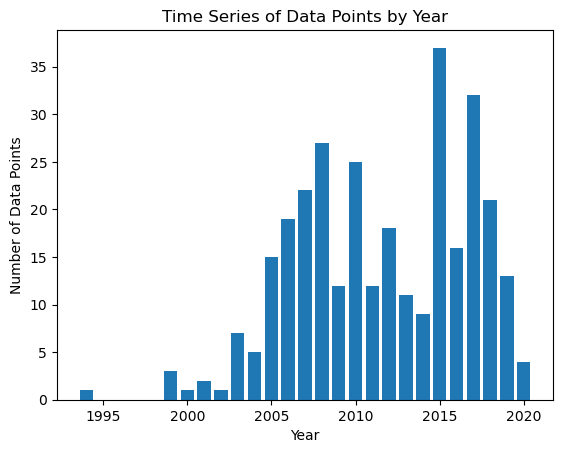

In [10]:
# Extract start times
all_meta = ld.drift_meta(ds_EAC, op_type='df')

# Extract the year from the 'time' variable
all_meta['year'] = all_meta['start_time'].dt.year

# Group by year and count the number of data points
yearly_counts = all_meta.groupby('year').count()['start_time']

# Create a bar plot
plt.bar(yearly_counts.index, yearly_counts)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Number of Drifters')
#plt.title('Time Series of Drifters per Year')

# Show the plot
plt.show()

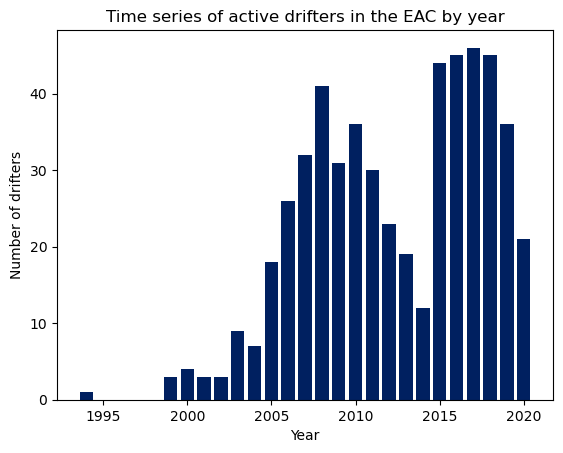

In [9]:
# Extract start times
df = ld.drift_meta(ds_EAC, op_type='df')

# Create a list to store the yearly counts
yearly_counts = []

# Loop through each row in the DataFrame
for _, row in df.iterrows():
    start_year = row['start_time'].year
    end_year = row['end_time'].year

    # Generate a list of years the data point is active
    years_active = list(range(int(start_year), int(end_year) + 1))

    # Add the years to the list
    yearly_counts.extend(years_active)

# Create a Pandas Series to count the occurrences of each year
yearly_counts = pd.Series(yearly_counts)

# Count the occurrences of each year
yearly_counts = yearly_counts.value_counts().sort_index()

# Create a bar plot
plt.bar(yearly_counts.index, yearly_counts, color='#002060')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Number of drifters')
plt.title('Time series of active drifters in the EAC by year')

# Show the plot
plt.show()

Plotting observation density on a grid. Using the 'grid_plot' function, we can provide a drifter ds to plot the number of observations in a n x n degree grid. A extent (like in the retrieve region function) can also be used, as well as a threshold array to remove values less than threshold[0] or greater than threshold[1].

26712.0


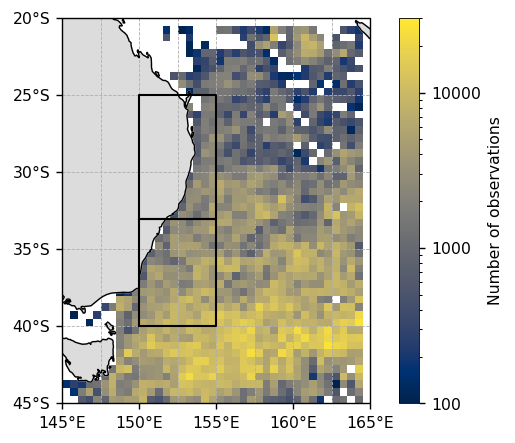

36323.0


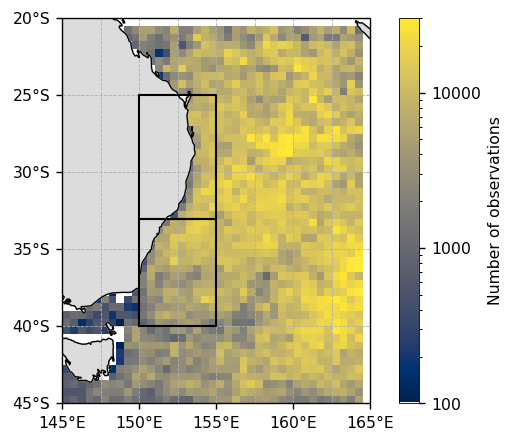

In [7]:
# PLOT THE OBSERVATION DENSITY IN A 0.5 DEGREE GRID FOR THE DROGUED  AND UNDROGUED EAC OBSERVATIONS
drogue_dense = ld.grid_plot(ds_drogue, n=0.5, threshold=[100,30000])
#ld.meta_series(arr=ds_drogue.dt.values, total_trajs=len(ds_drogue.traj), max_days=200, step_size=4)
undrogue_dense = ld.grid_plot(ds_undrogue, n=0.5, threshold=[100,30000])
#ld.meta_series(arr=ds_undrogue.dt.values, total_trajs=len(ds_undrogue.traj), max_days=200, step_size=4)

# NOTE: the black boxes in the two plots highlighting our other subsets (north and south)
# we can also plot the north and south as standalone plots using the same function
ld.grid_plot(ds_north_all)
ld.grid_plot(ds_south_all)

# Optionally, save the figures
#fig_path = ''
#drogue_dense.savefig(fig_path+'drogue_segmented_density.pdf')
#undrogue_dense.savefig(fig_path+'undrogue_segmented_density.pdf')

Plot Drifter survival series. Below the meta_series function is called again, this time using dictionaries of time delta arrays, to plot how many drifters remain active at each time step. The first example, is basic - just showing the undrogued and drogued total obserrvations in the EAC. However, the meta_series function is quite robust, and can take basically any dictionary of arrays as input. In the second example, we show some more combinations of survival series using different subsets.

Drogue total observations: 5969620
Undrogue total observations: 13419332
Array supplied, plotting survival
Drogued total trajectories:  2488
Undrogued total trajectories:  4004


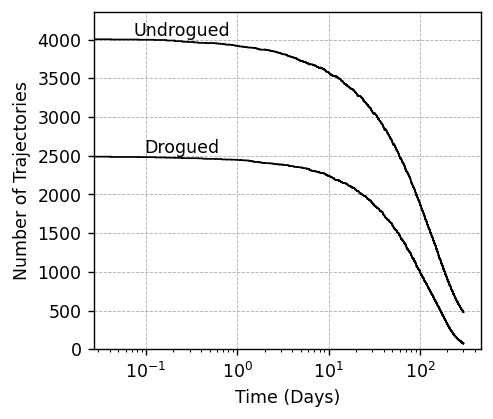

In [10]:

traj_dict = {
    'Drogued': {'array': ds_EAC_drogue.dt.values, 'color': 'black', 'total_traj': len(ds_EAC_drogue.ID)},
    'Undrogued': {'array': ds_EAC_undrogue.dt.values, 'color': 'black', 'total_traj': len(ds_EAC_undrogue.ID)}
}
print('Drogue total observations:', len(ds_EAC_drogue.dt.values))
print('Undrogue total observations:', len(ds_EAC_undrogue.dt.values))
ds_ts = ld.meta_series(trajectory_data=traj_dict, max_days=300, step_size=10, omit=False, tick_scaler=350)
ds_ts.savefig(fig_path+'drogue_undrogue_survival.eps', bbox_inches='tight', pad_inches=0.1)

Array supplied, plotting survival
Drogued total trajectories:  120
Undrogued total trajectories:  155
All total trajectories:  261


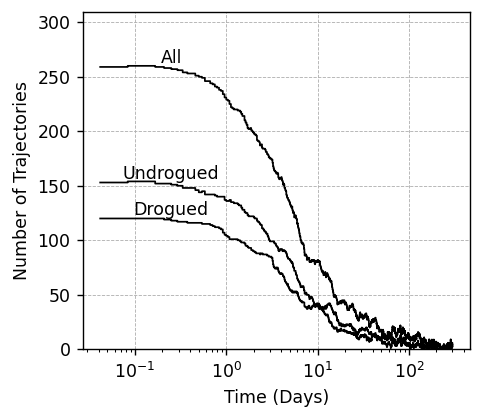

Array supplied, plotting survival
Drogued total trajectories:  360
Undrogued total trajectories:  315
All total trajectories:  655


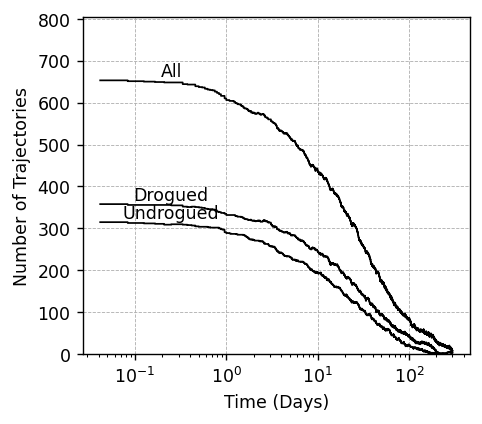

Array supplied, plotting survival
Drogued (N) total trajectories:  120
Undrogued (N) total trajectories:  155
North total trajectories:  261
Drogued (S) total trajectories:  360
Undrogued (S) total trajectories:  315
South total trajectories:  655


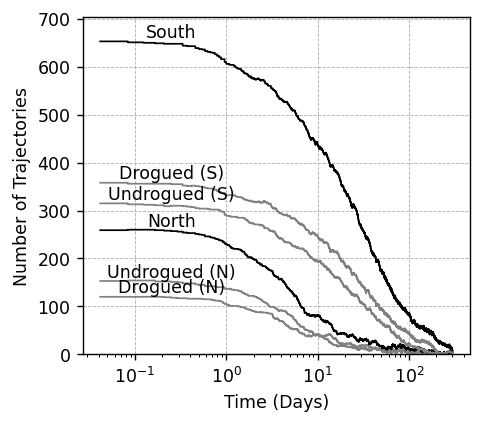

In [22]:
# USING meta_series TO PLOT THE NORTH AND SOUTH SUBSETS ON THE SAME FIGURE
traj_dict_north = {
    'Drogued': {'array': ds_north_drogued.dt.values, 'color': 'black', 'total_traj': len(ds_north_drogued.ID)},
    'Undrogued': {'array': ds_north_undrogued.dt.values, 'color': 'black', 'total_traj': len(ds_north_undrogued.ID)},
    'All': {'array': ds_north_all.dt.values, 'color': 'black', 'total_traj': len(ds_north_all.ID)}
}
north_survival = ld.meta_series(trajectory_data=traj_dict_north, max_days=300, step_size=10, omit=True, tick_scaler=50)
#north_survival.savefig(fig_path+'north_survival.eps', bbox_inches='tight', pad_inches=0.1)

traj_dict_south = {
    'Drogued': {'array': ds_south_drogued.dt.values, 'color': 'black', 'total_traj': len(ds_south_drogued.ID)},
    'Undrogued': {'array': ds_south_undrogued.dt.values, 'color': 'black', 'total_traj': len(ds_south_undrogued.ID)},
    'All': {'array': ds_south_all.dt.values, 'color': 'black', 'total_traj': len(ds_south_all.ID)}
}
south_survival = ld.meta_series(trajectory_data=traj_dict_south, max_days=300, step_size=10, omit=True, tick_scaler=150)
#south_survival.savefig(fig_path+'south_survival.eps', bbox_inches='tight', pad_inches=0.1)

traj_dict_all = {
    'Drogued (N)': {'array': ds_north_drogued.dt.values, 'color': 'grey', 'total_traj': len(ds_north_drogued.ID)},
    'Undrogued (N)': {'array': ds_north_undrogued.dt.values, 'color': 'grey', 'total_traj': len(ds_north_undrogued.ID)},
    'North': {'array': ds_north_all.dt.values, 'color': 'black', 'total_traj': len(ds_north_all.ID)},
    'Drogued (S)': {'array': ds_south_drogued.dt.values, 'color': 'grey', 'total_traj': len(ds_south_drogued.ID)},
    'Undrogued (S)': {'array': ds_south_undrogued.dt.values, 'color': 'grey', 'total_traj': len(ds_south_undrogued.ID)},
    'South': {'array': ds_south_all.dt.values, 'color': 'black', 'total_traj': len(ds_south_all.ID)}
}
all_survival = ld.meta_series(trajectory_data=traj_dict_all, max_days=300, step_size=10, omit=True, tick_scaler=50)
#all_survival.savefig(fig_path+'all_survival.eps', bbox_inches='tight', pad_inches=0.1)

Array supplied, plotting survival
0-5km total trajectories:  88
5-10km total trajectories:  88
10-20km total trajectories:  88
20-40km total trajectories:  88


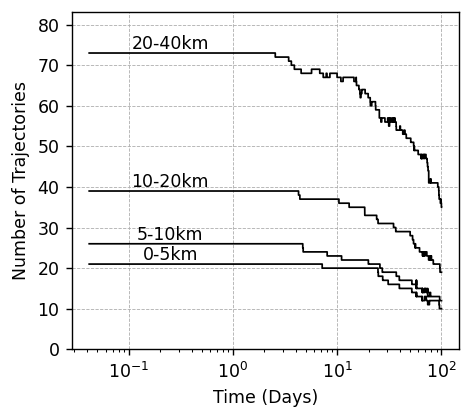

Array supplied, plotting survival
0-5km total trajectories:  88
5-10km total trajectories:  88
10-20km total trajectories:  88
20-40km total trajectories:  88


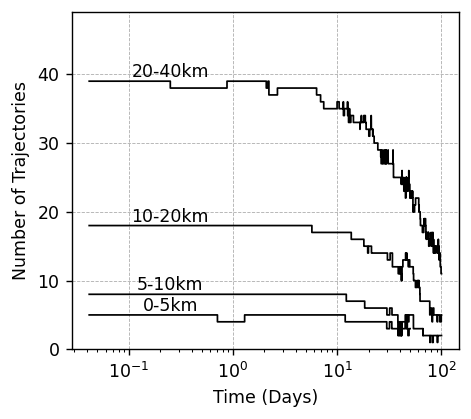

In [71]:
# meta_series CAN ALSO BE USED TO PLOT THE SURVIVAL OF PAIR TRAJECTORIES DETERMINED THROUGH THE find_chance_pairs FUNCTION
drogue_traj_dict = {
    '0-5km': {'array': drogue_ori_sep_5km['dt'], 'color': 'black'},
    '5-10km': {'array': drogue_ori_sep_10km['dt'], 'color': 'black'},
    '10-20km': {'array': drogue_ori_sep_20km['dt'], 'color': 'black'},
    '20-40km': {'array': drogue_ori_sep_40km['dt'], 'color': 'black'}
}

drogue_pairs = ld.meta_series(trajectory_data=drogue_traj_dict, max_days=100, step_size=1, tick_scaler=10)
#drogue_pairs.savefig(fig_path+'drogue_pairs.eps', bbox_inches='tight', pad_inches=0.1)

undrogue_traj_dict = {
    '0-5km': {'array': undrogue_ori_sep_5km['dt'], 'color': 'black'},
    '5-10km': {'array': undrogue_ori_sep_10km['dt'], 'color': 'black'},
    '10-20km': {'array': undrogue_ori_sep_20km['dt'], 'color': 'black'},
    '20-40km': {'array': undrogue_ori_sep_40km['dt'], 'color': 'black'}
}

undrogue_pairs = ld.meta_series(trajectory_data=undrogue_traj_dict, max_days=100, step_size=1, tick_scaler=10)
#undrogue_pairs.savefig(fig_path+'undrogue_pairs.eps', bbox_inches='tight', pad_inches=0.1)

# Single particle statistics
Absolute dispersal is calculated by taking the squared distance from a start point. The 'cohort_displace' function does this for each drifter at each timestep. First, one can also segment trajectories (i.e., duplicate trajectories after every ~ T^L days) to improve the degrees of freedom. We determine T^L by first computing the autocorrelation or autocovarience which gives us T^L.

In [ ]:
# AUTOCORRELATIONS AND TIMESCALES FOR DROGUED AND UNDROGUED EAC DRIFTERS
ds_EAC_drogued['v_total'] = np.sqrt(ds_EAC_drogued.vn.values ** 2 + ds_EAC_drogued.ve.values ** 2)
ds_EAC_undrogued['v_total'] = np.sqrt(ds_EAC_undrogued.vn.values ** 2 + ds_EAC_undrogued.ve.values ** 2) # Calculate total velocities and store in the ds

velocities, devs, u_devs, v_devs, traj_dts = ld.get_velocities(ds_EAC_drogued, primes=True) # Get velocities is used to extract the data arrays required for the autocorrelation
tl = ld.plot_autocorrelations(devs, u_devs, v_devs, traj_dts, max_x=15) # Setting max_x sets where the x axis is cut-off NOT where it integrates up to 

velocities_ud, devs_ud, u_devs_ud, v_devs_ud, traj_dts_ud = ld.get_velocities(ds_EAC_undrogued, primes=True)
tl_ud = ld.plot_autocorrelations(devs_ud, u_devs_ud, v_devs_ud, traj_dts_ud, max_x=15)

In [ ]:
# ALL EAC DRIFTERS #
# NOTE: uncomment steps as required

#ds_filt = ld.retrieve_region(ds=ds_EAC, full=False, debug=False) #not_ids=[139659, 300234062321340, 300234063430970, 101528, 101920] # Filter out erroneous trajs if required
#ds_drogue_ori, ds_undrogue_ori = ld.drogue_subset(ds_filt.drop_vars(['disp_x','disp_y','displacement','A2','disp_x2','disp_y2'])) #Seperate drogued and undrogued observations
#ds_drogue_ori.to_netcdf(path+'drogue_ori.nc', mode='w', encoding=ds_encoding)
#ds_undrogue_ori.to_netcdf(path+'undrogue_ori_tmp.nc', mode='w', encoding=ds_encoding)

ds_drogue_seg = ld.segments(ds=ds_EAC_drogued, Tl=10) # segment each trajectory at every time > Lagrangian autocorrolation length
ds_undrogue_seg = ld.segments(ds=ds_EAC_undrogued, Tl=10)
#ds_drogue_seg.to_netcdf(path+'drogue_segmented.nc', mode='w')
#ds_undrogue_seg.to_netcdf(path+'undrogue_segmented.nc', mode='w')

ds_drogue_seg_disp = ld.cohort_displace(ds=ds_drogue_seg, sub_mean=True, tau=20) # Calculate absolute dispersion for each dataset
ds_undrogue_seg_disp = ld.cohort_displace(ds=ds_undrogue_seg, sub_mean=True, tau=20) # NOTE: if the process is very slow, try setting tau=None
#ds_drogue_seg_disp.to_netcdf(path+'drogue_segmented_submean.nc', mode='w')
#ds_undrogue_seg_disp.to_netcdf(path+'undrogue_segmented_submean_tmp.nc', mode='w')
#ds_undrogue_seg_disp

We also calculate eddy diffusivity using the 'disp_tensor' function. The tensor is constructed using displacement values at asymptotic (i.e., T_inf) time lags and velocity deviations (See the paper associated with this code or Zhurbas et al 2014 for more information).

In [ ]:
# CALCULATE DIFFUSIVITY TENSOR FOR DROGUED AND UNDROGUED EAC DRIFTERS
# NOTE: cohort_displace must be run before this with tau set to a real value (i.e., not none), where tau is the T_inf timestep to integrate up to
ds_undrogue_k = ld.disp_tensor(ds=ds_undrogue_seg_disp, res=0.5)
ds_drogue_k = ld.disp_tensor(ds=ds_drogue_seg_disp, res=0.5)
#print('Saving dispersion tensors.')
#ds_undrogue_k.to_netcdf(path+'undrogue_tensor.nc', mode='w')
#ds_drogue_k.to_netcdf(path+'drogue_tensor.nc', mode='w')

#ds_drogue_k
#ds_undrogue_k

Likewise, we can also run the same functions on other subsets (such as the north and south EAC subsets). However, check the data density of smaller subsets such as these, as some calculations will not work well with low degrees of freedom - especially gridding functions such as the disp_tensor.

In [ ]:
# NORTH AND SOUTH EAC SUBSET DISPERSION
ds_south_all_seg = ld.segments(ds_south)
ds_south_all = ld.cohort_displace(ds_south_all_seg, sub_mean=True)

ds_north_all_seg = ld.segments(ds_north)
ds_north_all = ld.cohort_displace(ds_north_all_seg, sub_mean=True)

# SUMMER AND WINTER DISPERSION AND DIFFUSIVITY TENSORS
ds_winter_disp = ld.cohort_displace(ds=ds_winter_drogue, sub_mean=False, tau=20)
ds_summer_disp = ld.cohort_displace(ds=ds_summer_drogue, sub_mean=False, tau=20)

tensor_winter = ld.disp_tensor(ds=ds_winter_disp, res=0.5)
tensor_winter
tensor_summer = ld.disp_tensor(ds=ds_summer_disp, res=0.5)
tensor_summer


Finally, we plot the dispersion time series and then map the lateral eddy diffusivity.

In [ ]:
# PLOT ABSOLUTE DISPERSION#

# Define the functions to use in the plot where range is the xrange to plot over, and power is the power law relationship
fit_funcs = {'f1': {'range': (0,3), 'power': 2, 'coef': 10**3},
            'f2': {'range': (4, 800), 'power': 1, 'coef': 10**3}}

# Create the plots with fit regression lines and theoretical lines
undrogued_abs = ld.dispersal_plot(ds=ds_EAC_undrogued, scatter=True, components=True, total=True, cmap=None, norm=None,
                    disp_funcs=fit_funcs, best_fit=True, title='', ci=False, theoretical=True)
#undrogued_abs.savefig(fig_path+'undrogue_abs.pdf', bbox_inches='tight', pad_inches=0.1)
#undrogued_abs.savefig(fig_path+'undrogue_abs.jpg', bbox_inches='tight', pad_inches=0.1)

drogued_abs = ld.dispersal_plot(ds=ds_EAC_drogued, scatter=True, components=True, total=True, cmap=None, norm=None,
                    disp_funcs=fit_funcs, best_fit=True, title='', ci=False, theoretical=True)
#drogued_abs.savefig(fig_path+'drogue_abs.pdf', bbox_inches='tight', pad_inches=0.1)
#drogued_abs.savefig(fig_path+'drogue_abs.jpg', bbox_inches='tight', pad_inches=0.1)

f1
      slope  intercept   r_value  p_value   std_err
0  1.861337   3.120401  0.749074      0.0  0.010557
f2
      slope  intercept  r_value  p_value   std_err
0  0.382443   4.040528  0.21752      0.0  0.005131


C:\Users\z5493451\OneDrive - UNSW\Documents\Python Scripts\ldrift\drift_funcs.py:2910: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 300)


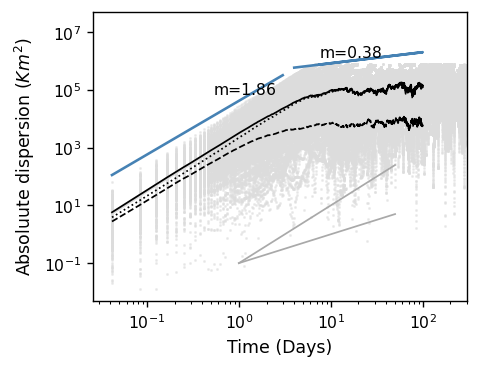

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


f1
      slope  intercept   r_value  p_value   std_err
0  1.807744   2.902813  0.709119      0.0  0.007783
f2
      slope  intercept   r_value  p_value   std_err
0  0.696548    3.53117  0.370961      0.0  0.002276


C:\Users\z5493451\OneDrive - UNSW\Documents\Python Scripts\ldrift\drift_funcs.py:2910: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 300)


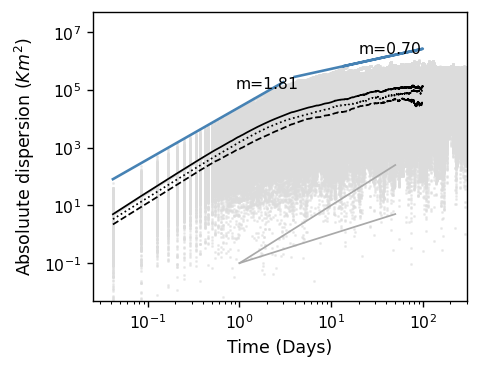

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [18]:
# DISPERSION TIME SERIES (NORTH AND SOUTH SUBSETS)
fit_funcs = {'f1': {'range': (0,3), 'power': 2, 'coef': 10**3},
            'f2': {'range': (4, 100), 'power': 1, 'coef': 10**3}}
north_fit_funcs = fit_funcs
south_fit_funcs = fit_funcs

# Alternatively, we can also fit the relationships first before plotting using find_breakpoints.
# This will provide extra information, such as significance and all parameters.
#north_fit_funcs = find_breakpoints(ds=ds_north_all, guess=[np.log10(3)])
#south_fit_funcs = find_breakpoints(ds=ds_south_all, guess=[np.log10(3)])
#north_fit_funcs = find_breakpoints(ds=ds_north_all, num_breakpoints=2)
#south_fit_funcs = find_breakpoints(ds=ds_south_all, num_breakpoints=2)

north_all_tmp = dispersal_plot(ds=ds_north_all, scatter=True, components=True, total=True, cmap=None, norm=None,
                    disp_funcs=north_fit_funcs, best_fit=True, title='', theoretical=True, ci=False)
#north_all_tmp.savefig(fig_path+'north_both_abs.eps', bbox_inches='tight', pad_inches=0.1)

south_all_tmp = dispersal_plot(ds=ds_south_all, scatter=True, components=True, total=True, cmap=None, norm=None,
                    disp_funcs=south_fit_funcs, best_fit=True, title='', theoretical=True, ci=False)
#south_all_tmp.savefig(fig_path+'south_both_abs.eps', bbox_inches='tight', pad_inches=0.1)

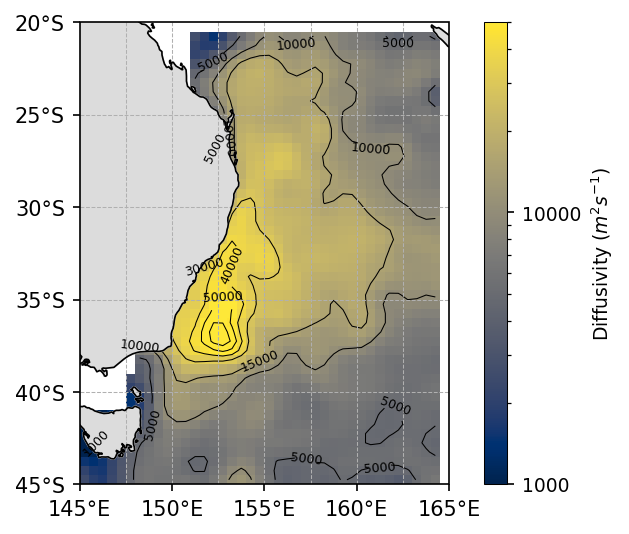

In [7]:
# UNDROGUED DIFFUSIVITY #
domain=[145, 165, -45, -20]
ds_undrogue_k['v_total'] = np.sqrt(ds_undrogue_k.ve.values ** 2 + ds_undrogue_k.vn.values ** 2)
points = np.column_stack((ds_undrogue_k.longitude.values.flatten(), ds_undrogue_k.latitude.values.flatten()))
mean_df_ud = ld.grid_data(points=points, u=ds_undrogue_k.ve.values.flatten(), v=ds_undrogue_k.vn.values.flatten(),
                    total=ds_undrogue_k.v_total.values.flatten(),
                    sst=ds_undrogue_k.sst.values.flatten(), time=np.int64(ds_undrogue_k.time.values.flatten()),
                    d_x2=ds_undrogue_k.d_x2.values, d_y2=ds_undrogue_k.d_y2.values, d_A2=ds_undrogue_k.d_A2.values,
                    total_prime=abs(ds_undrogue_k.total_prime.values.flatten()),
                    u_prime=ds_undrogue_k.u_prime.values.flatten(),
                    v_prime=ds_undrogue_k.v_prime.values.flatten(),
                    d_prime=ds_undrogue_k.d_prime.values.flatten(),
                    displacement=ds_undrogue_k.displacement.values.flatten(),
                    Davis_diff=ds_undrogue_k.lateral_diffusivity.values.flatten(),
                    domain=domain, res=0.5, threshold = 100)
#mean_df.head()

undrogue_diff = ld.plot_meshgrid_on_map(df=mean_df_ud, grid_var='Davis_diff', domain=[145, 165, -45, -20], sigma=1.1, cb_range=[1000, 50000])
#undrogue_diff.savefig(fig_path+'undrogued_diffusivity_half_deg.eps')

In [ ]:
# DROGUED DIFFUSIVITY #
domain = [145, 165, -45, -20]

ds_drogue_k['v_total'] = np.sqrt(ds_drogue_k.ve.values ** 2 + ds_drogue_k.vn.values ** 2)
points2 = np.column_stack((ds_drogue_k.longitude.values.flatten(), ds_drogue_k.latitude.values.flatten()))
mean_df2 = ld.grid_data(points=points2, u=ds_drogue_k.ve.values.flatten(), v=ds_drogue_k.vn.values.flatten(),
                    total=ds_drogue_k.v_total.values.flatten(),
                    sst=ds_drogue_k.sst.values.flatten(), time=np.int64(ds_drogue_k.time.values.flatten()),
                    d_x2=ds_drogue_k.d_x2.values, d_y2=ds_drogue_k.d_y2.values, d_A2=ds_drogue_k.d_A2.values,
                    total_prime=abs(ds_drogue_k.total_prime.values.flatten()),
                    u_prime=ds_drogue_k.u_prime.values.flatten(),
                    v_prime=ds_drogue_k.v_prime.values.flatten(),
                    d_prime=ds_drogue_k.d_prime.values.flatten(),
                    displacement=ds_drogue_k.displacement.values.flatten(),
                    Davis_diff=ds_drogue_k.lateral_diffusivity.values.flatten(),
                    domain=domain, res=0.5, threshold = 100)
#mean_df.head()

drogue_diff = ld.plot_meshgrid_on_map(df=mean_df2, grid_var='Davis_diff', domain=[145, 165, -45, -20], sigma=1.1, cb_range=[1000, 50000])
#drogue_diff.savefig(fig_path+'drogued_diffusivity_half_deg.eps')

In [ ]:
# SUMMER DIFFUSIVITY #
domain=[145, 165, -45, -20]

tensor_summer['v_total'] = np.sqrt(tensor_summer.ve.values ** 2 + tensor_summer.vn.values ** 2)
points = np.column_stack((tensor_summer.longitude.values.flatten(), tensor_summer.latitude.values.flatten()))
mean_df_summer = ld.grid_data(points=points, u=tensor_summer.ve.values.flatten(), v=tensor_summer.vn.values.flatten(),
                    total=tensor_summer.v_total.values.flatten(),
                    sst=tensor_summer.sst.values.flatten(), time=np.int64(tensor_summer.time.values.flatten()),
                    d_x2=tensor_summer.d_x2.values, d_y2=tensor_summer.d_y2.values, d_A2=tensor_summer.d_A2.values,
                    total_prime=abs(tensor_summer.total_prime.values.flatten()),
                    u_prime=tensor_summer.u_prime.values.flatten(),
                    v_prime=tensor_summer.v_prime.values.flatten(),
                    d_prime=tensor_summer.d_prime.values.flatten(),
                    displacement=tensor_summer.displacement.values.flatten(),
                    Davis_diff=tensor_summer.lateral_diffusivity.values.flatten(),
                    domain=domain, res=0.5, threshold = 100)
#mean_df.head()

summer_diff = ld.plot_meshgrid_on_map(df=mean_df_summer, grid_var='Davis_diff', domain=[145, 165, -45, -20], sigma=1.1, cb_range=[1000, 50000])
#summer_diff.savefig(fig_path+'summer_drogue_diffusivity.eps')

In [ ]:
# WINTER DIFFUSIVITY #
domain=[145, 165, -45, -20]

tensor_winter['v_total'] = np.sqrt(tensor_winter.ve.values ** 2 + tensor_winter.vn.values ** 2)
points = np.column_stack((tensor_winter.longitude.values.flatten(), tensor_winter.latitude.values.flatten()))
mean_df_w = ld.grid_data(points=points, u=tensor_winter.ve.values.flatten(), v=tensor_winter.vn.values.flatten(),
                    total=tensor_winter.v_total.values.flatten(),
                    sst=tensor_winter.sst.values.flatten(), time=np.int64(tensor_winter.time.values.flatten()),
                    d_x2=tensor_winter.d_x2.values, d_y2=tensor_winter.d_y2.values, d_A2=tensor_winter.d_A2.values,
                    total_prime=abs(tensor_winter.total_prime.values.flatten()),
                    u_prime=tensor_winter.u_prime.values.flatten(),
                    v_prime=tensor_winter.v_prime.values.flatten(),
                    d_prime=tensor_winter.d_prime.values.flatten(),
                    displacement=tensor_winter.displacement.values.flatten(),
                    Davis_diff=tensor_winter.lateral_diffusivity.values.flatten(),
                    domain=domain, res=0.5, threshold = 100)
#mean_df.head()
winter_diff = ld.plot_meshgrid_on_map(df=mean_df_w, grid_var='Davis_diff', domain=[145, 165, -45, -20], sigma=1, cb_range=[1000, 50000])
#winter_diff.savefig(fig_path+'winter_drogue_diffusivity.eps')

# Pairwise Statistics (Relative dispersion)
In this section, first pairs are identified (this includes initial pairs and chance pairs as the find_chance_pairs function naturally also finds initial pairs), and then a subset is created containing only drifters that are at one stage or another a pair. Using this dataset, the separation distance is calculated for each pair at each time step and used to determine the relative dispersal across different starting separations.

The first step, below, is to find the IDs, times, and lat/lons of drifters that have a pair(s).

In [13]:
# NOTE: Make sure the original trajectories are used to find pairs (not the segmented trajectories) as
    # 1) Pairs may not follow the same decorrelation timescale as single trajectories and
    # 2) The pairwise functions (especially the FSLE) are the most computationally strenuous, so it will take time
 
#undrogue_ori_cp_5km = ld.find_chance_pairs(ds_undrogue_ori, ddist=[0, 5], dt=0) 
#undrogue_ori_cp_10km = ld.find_chance_pairs(ds_undrogue_ori, ddist=[5, 10], dt=0)
#undrogue_ori_cp_20km = ld.find_chance_pairs(ds_undrogue_ori, ddist=[10, 20], dt=0)
#undrogue_ori_cp_40km = ld.find_chance_pairs(ds_undrogue_ori, ddist=[20, 40], dt=0)

drogue_ori_cp_5km = ld.find_chance_pairs(ds_drogue_ori, ddist=[0, 5], dt=0) # Find ALL pairs with starting (where t_p = t_q) distance between 0 and 5km
drogue_ori_cp_10km = ld.find_chance_pairs(ds_drogue_ori, ddist=[5, 10], dt=0) # NOTE: we will limit our analysis to just drogued drifters in this example
drogue_ori_cp_20km = ld.find_chance_pairs(ds_drogue_ori, ddist=[10, 20], dt=0)
drogue_ori_cp_40km = ld.find_chance_pairs(ds_drogue_ori, ddist=[20, 40], dt=0)

#both_ori_cp_5km = find_chance_pairs(ds_EAC, ddist=[0, 5], dt=0) # Use to find drifter pairs regardless of drogue status
#both_ori_cp_10km = find_chance_pairs(ds_EAC, ddist=[5, 10], dt=0)
#both_ori_cp_20km = find_chance_pairs(ds_EAC, ddist=[10, 20], dt=0)
#both_ori_cp_40km = find_chance_pairs(ds_EAC, ddist=[20, 40], dt=0)

Next, we create data subsets containing only drifters that have a valid pair(s). 

In [14]:
# NOTE: that we only do the whole process for drogued drifters in this example. For Both or undrogued drifters, the process is the same.

cp_ids = np.unique(pd.concat([drogue_ori_cp_5km['ID_first'], drogue_ori_cp_5km['ID_second']]))
pairs_subset = ld.get_traj_cols(ld.retrieve_region(ds, ids=cp_ids))

cp_ids_10km = np.unique(pd.concat([drogue_ori_cp_10km['ID_first'], drogue_ori_cp_10km['ID_second']]))
pairs_subset_10km = ld.get_traj_cols(ld.retrieve_region(ds, ids=cp_ids_10km))

cp_ids_20km = np.unique(pd.concat([drogue_ori_cp_20km['ID_first'], drogue_ori_cp_20km['ID_second']]))
pairs_subset_20km = ld.get_traj_cols(ld.retrieve_region(ds, ids=cp_ids_20km))

cp_ids_40km = np.unique(pd.concat([drogue_ori_cp_40km['ID_first'], drogue_ori_cp_40km['ID_second']]))
pairs_subset_40km = ld.get_traj_cols(ld.retrieve_region(ds, ids=cp_ids_40km))


And now we can call the 'cohort_pair_sep' function to calculate relative dispersion.

In [16]:
drogue_ori_sep_5km = ld.cohort_pair_sep(cp_df=drogue_ori_cp_5km, ds=pairs_subset)
drogue_ori_sep_10km = ld.cohort_pair_sep(cp_df=drogue_ori_cp_10km, ds=pairs_subset_10km)
drogue_ori_sep_20km = ld.cohort_pair_sep(cp_df=drogue_ori_cp_20km, ds=pairs_subset_20km)
drogue_ori_sep_40km = ld.cohort_pair_sep(cp_df=drogue_ori_cp_40km, ds=pairs_subset_40km)

100%|██████████| 150/150 [03:42<00:00,  1.48s/it]


Before we plot the relative dispersion, we will also show the pair trajectories on a map similar to the spagheti plot we made previously. The 'pairs_driftplot' takes any list of dataframes containing the lat/lon of pairs and plots them on a map. You can also add original (single) trajectories and change markers, colours, and opacity (see the function documentation).

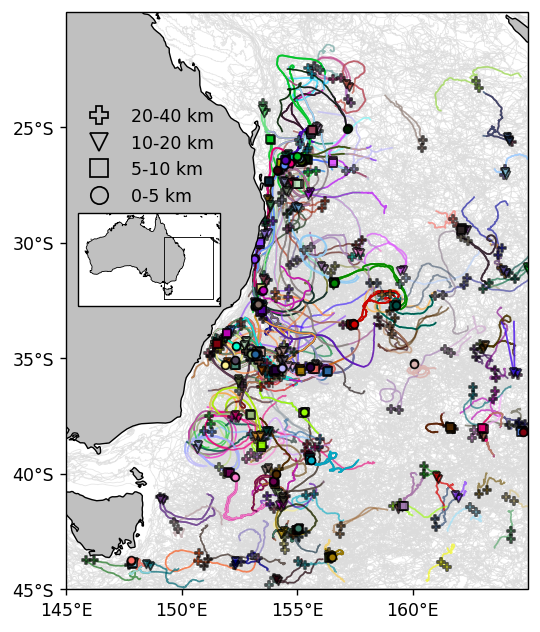

In [32]:
# NOTE: By taking sep_df[sep_df['dt'] < 10 * 3600 * 24], we only plot the first 10 days of the pair trajectory
df_list = [drogue_ori_sep_40km[drogue_ori_sep_40km['dt'] < 10 * 3600 * 24], drogue_ori_sep_20km[drogue_ori_sep_20km['dt'] < 10 * 3600 * 24],
           drogue_ori_sep_10km[drogue_ori_sep_10km['dt'] < 10 * 3600 * 24], drogue_ori_sep_5km[drogue_ori_sep_5km['dt'] < 10 * 3600 * 24]]

pairdp = ld.pair_driftplot(df_list=df_list, ds=ds_EAC, ls=['-', '-', '-', '-'], symbols=['P', 'v', 's', 'o']) #NOTE: ds is optional - if given it plots like 'driftplot'
#pairdp.savefig(fig_path+'drifter_pairs_map.pdf', bbox_inches='tight', pad_inches=0.1)

# ------------------------------------------- ----------------------- SOME OTHER EXAMPLES ---------------------------------------------------------------------------- #
#df_list1 = [both_ori_sep_40km[both_ori_sep_40km['dt'] < 10 * 3600 * 24], both_ori_sep_5km[both_ori_sep_5km['dt'] < 10 * 3600 * 24]]
#df_list2 = [both_ori_sep_20km[both_ori_sep_20km['dt'] < 10 * 3600 * 24], both_ori_sep_10km[both_ori_sep_10km['dt'] < 10 * 3600 * 24]]

#pairdp1 = pair_driftplot(df_list=df_list1, ds=ds, ls=['-', '-', '-', '-'], symbols=['o', '*'], labels=['20-40 km', '0-5 km'])
#pairdp2 = pair_driftplot(df_list=df_list2, ds=ds, ls=['-', '-', '-', '-'], symbols=['o', '*'], labels=['10-20 km', '5-10 km'])

#pairdp_40 = pair_driftplot(df_list=[both_ori_sep_40km[both_ori_sep_40km['dt'] < 10 * 3600 * 24]], ds=ds, labels=['20-40 km'], symbols=['o'], ls=['-', '-', '-', '-'])
#pairdp_20 = pair_driftplot(df_list=[both_ori_sep_20km[both_ori_sep_20km['dt'] < 10 * 3600 * 24]], ds=ds, labels=['10-20 km'], symbols=['o'], ls=['-', '-', '-', '-'])
#pairdp_10 = pair_driftplot(df_list=[both_ori_sep_10km[both_ori_sep_10km['dt'] < 10 * 3600 * 24]], ds=ds, labels=['5-10 km'], symbols=['o'], ls=['-', '-', '-', '-'])
#pairdp_5 = pair_driftplot(df_list=[both_ori_sep_5km[both_ori_sep_5km['dt'] < 10 * 3600 * 24]], ds=ds, labels=['0-5 km'], symbols=['o'], ls=['-', '-', '-', '-'])

In [35]:

def delta_filter_a(df, max_delta=7200, max_dt=100 * 24 * 3600):
    # Calculate the time difference
    df['time_diff'] = (df['time_second'] - df['time_first']).abs()
    # Filter rows where the time difference is greater than 1 hour
    filtered_df = df[df['time_diff'] <= max_delta]
    filtered_df = filtered_df[filtered_df['dt'] <= max_dt]
    # Drop the 'time_diff' column if it's no longer needed
    filtered_df = filtered_df.drop(columns=['time_diff'])
    #print(len(filtered_df))
    #print(len(df))
    return filtered_df[filtered_df['D2'] > 0]

#drogue_ori_sep_20km = delta_filter_a(drogue_ori_sep_20km)
#drogue_ori_sep_20km

To plot the relative dispersion, we still call the 'dispersal_plot' function, however, this time we provide a different set of functions to fit based on the theory of relative dispersion. The function will automatically switch between absolute and relative dispersion depending on if a dataframe (df) or dataset (ds) is provided.

Dataframe supplied - attempting to plot relative dispersal...
exp:f0
      slope  intercept   r_value       p_value   std_err
0  1.674243   0.877466  0.236589  4.587864e-11  0.250564
f1
      slope  intercept   r_value  p_value   std_err
0  2.364802   0.773315  0.437019      0.0  0.051207
f2
      slope  intercept   r_value        p_value   std_err
0  0.991102   2.656004  0.139226  1.901376e-109  0.044372


C:\Users\z5493451\OneDrive - UNSW\Documents\Python Scripts\ldrift\drift_funcs.py:2923: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 300)


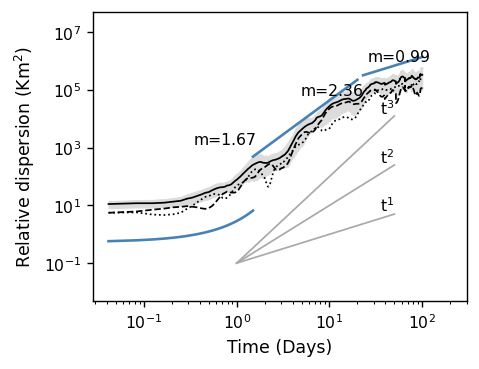

Dataframe supplied - attempting to plot relative dispersal...
exp:f0
      slope  intercept   r_value       p_value   std_err
0  0.875824    3.36372  0.270267  3.942374e-17  0.102089
f1
      slope  intercept   r_value        p_value   std_err
0  1.846101   1.686597  0.423034  1.427175e-263  0.050625
f2
      slope  intercept   r_value        p_value   std_err
0  0.648669   3.116662  0.117655  1.017086e-104  0.029744


C:\Users\z5493451\OneDrive - UNSW\Documents\Python Scripts\ldrift\drift_funcs.py:2923: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 300)


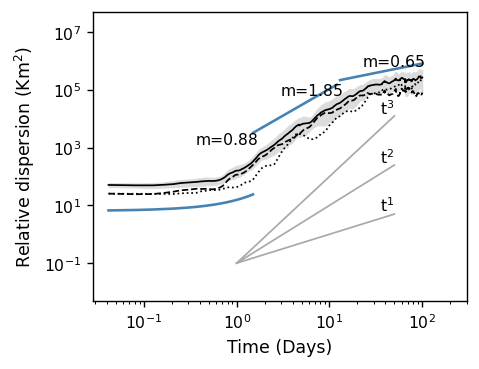

Dataframe supplied - attempting to plot relative dispersal...
f2
      slope  intercept   r_value  p_value   std_err
0  1.036278   2.814864  0.347697      0.0  0.010882


C:\Users\z5493451\OneDrive - UNSW\Documents\Python Scripts\ldrift\drift_funcs.py:2923: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 300)


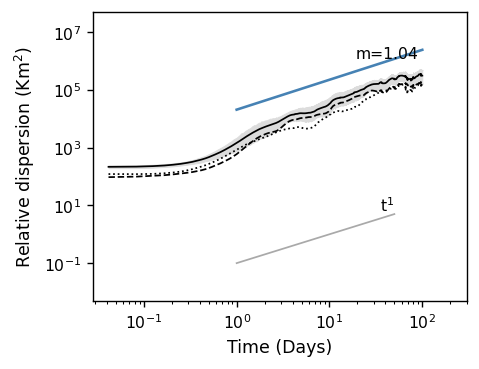

Dataframe supplied - attempting to plot relative dispersal...
f2
      slope  intercept   r_value  p_value   std_err
0  0.865527   3.388714  0.347718      0.0  0.006634


C:\Users\z5493451\OneDrive - UNSW\Documents\Python Scripts\ldrift\drift_funcs.py:2923: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 300)


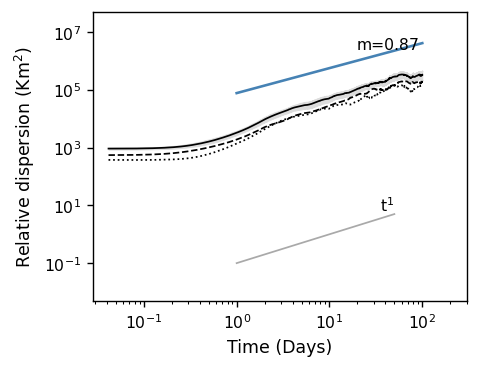

In [44]:
# DEFINE THE FUNCTIONS TO FIT TO THE DATA #
#   NOTE: Use 'exp:f0' for the exponential distribution

d_funcs_5km = {'exp:f0': {'range': (0, 1.5), 'power': 1},
            'f1': {'range': (1.5, 20), 'power': 3},
            'f2': {'range': (23, 100), 'power': 1},
            'f4': {'range': (0, 0), 'power': 2}}
d_funcs_10km = {'exp:f0': {'range': (0, 1.5), 'power': 1},
            'f1': {'range': (1.5, 12), 'power': 2},
            'f2': {'range': (13, 100), 'power': 1},
            'f4': {'range': (0, 0), 'power': 3}}
d_funcs_20km = {
            'f2': {'range': (1, 100), 'power': 1},
            }
d_funcs_40km = {
            'f2': {'range': (1, 100), 'power': 1},
            }

# NOTE: ldrift also contains a function to plot PDFS (but NEEDS UPDATING / FIXING)

drogue_5km_rel_plot = ld.dispersal_plot(df=drogue_ori_sep_5km, total=True,
                                    components=True, best_fit=True, scatter=False,
                                    title='', disp_funcs=d_funcs_5km, theoretical=True)
#PDF_plot(drogue_ori_sep_5km[drogue_ori_sep_5km['dt'] == 3 * 24 * 3600]['sep_distance'], type='exp', n=6)
drogue_5km_rel_plot.savefig(fig_path+'drogue_5km_rel_plot.eps', bbox_inches='tight', pad_inches=0.1)

drogue_10km_rel_plot = ld.dispersal_plot(df=drogue_ori_sep_10km, total=True,
                                    components=True, best_fit=True, scatter=False,
                                    title='', disp_funcs=d_funcs_10km, theoretical=True)
#PDF_plot(drogue_ori_sep_10km[drogue_ori_sep_10km['dt'] == 3 * 24 * 3600]['sep_distance'], type='exp', n=len(np.unique(drogue_ori_sep_10km['ID_marker'])))
#PDF_plot(drogue_ori_sep_10km[drogue_ori_sep_10km['dt'] == 3 * 24 * 3600]['sep_distance'], type='exp', n=6)
drogue_10km_rel_plot.savefig(fig_path+'drogue_10km_rel_plot.eps', bbox_inches='tight', pad_inches=0.1)


drogue_20km_rel_plot = ld.dispersal_plot(df=drogue_ori_sep_20km, total=True,
                                    components=True, best_fit=True, scatter=False,
                                    title='', disp_funcs=d_funcs_20km, theoretical=True)
#PDF_plot(drogue_ori_sep_20km[drogue_ori_sep_20km['dt'] == 3 * 24 * 3600]['sep_distance'], type='exp', n=6)
drogue_20km_rel_plot.savefig(fig_path+'drogue_20km_rel_plot.eps', bbox_inches='tight', pad_inches=0.1)

drogue_40km_rel_plot = ld.dispersal_plot(df=drogue_ori_sep_40km, total=True,
                                    components=True, best_fit=True, scatter=False,
                                    title='', disp_funcs=d_funcs_40km, theoretical=True)
#PDF_plot(drogue_ori_sep_40km[drogue_ori_sep_40km['dt'] == 3 * 24 * 3600]['sep_distance'], type='exp', n=6)
drogue_40km_rel_plot.savefig(fig_path+'drogue_40km_rel_plot.eps', bbox_inches='tight', pad_inches=0.1) 

# Pairwise Statistics (Finite-Scale Lyapunov Exponents)
The last piece of analysis we will do in this example notebook, is to calculate the Finite-Scale LYapunov Exponent (FSLE) of the drogued drifters in the EAC (as with before, the same process can be applied to any other subset of the GDP or similar dataset).

First, we find ALL pairs for EVERY drifter in the dataset, regardless of their separation distance (this is the most computationally straining part). We then filter out values between some range of starting separations (as well as erroneous data) and calculate the FSLE using 'compute_fsle'. 


In [66]:
# NOTE-ing again, that we only use original trajectories
EAC_DROGUE_PAIRS = ld.rel_disp(ds=ds_EAC_drogued) # I KNOW it's called 'rel_disp' but it does just that: calculate displacements relative to another particle
EAC_DROGUE_FSLE = ld.compute_fsle(df=EAC_DROGUE_PAIRS, threshold_rate=np.sqrt(2)) # plus THIS is the one that actually calculates the FSLE (which is the fast part)

#EAC_DROGUE_FSLE.to_csv(path+'ALL_DROGUE_FSLE.csv') # Recommend saving so you don't have to do all of that again

Below, is an additional filter function that can be used to narrow down the range of distances being included (i.e., between 0 km and 3100 km initially); you can also specify certain drifters to remove from the dataframe if they are missbehaving.

In [47]:
# OPTIONAL FILTERING FUNCTION #
def delta_filter(df, max_delta=3100, min_delta=0):
    # Apply the filter to the dataframe
    filtered_df = df.groupby('ID_marker').filter(
        lambda group: (group['sep_distance'].iloc[0] > min_delta) and
                      (group['sep_distance'].iloc[0] <= max_delta) and
                      (group['comp_ID'].iloc[0] != 139659) and
                      (group['ID'].iloc[0] != 139659)
    )

    # Print the number of pairs in the filtered dataframe
    num_unique_ids = filtered_df['ID_marker'].nunique()
    print(f"Number of pairs in the filtered DataFrame: {num_unique_ids}")

    return filtered_df

# Use the filter on the EAC dataframe
filtered_df = delta_filter(EAC_DROGUE_FSLE)
#df_5km = delta_filter(EAC_DROGUE_FSLE, max_delta=5)
#df_10km = delta_filter(EAC_DROGUE_FSLE, min_delta=5, max_delta=20)
#df_20km = delta_filter(EAC_DROGUE_FSLE, min_delta=20, max_delta=50)
#df_40km = delta_filter(EAC_DROGUE_FSLE, min_delta=20, max_delta=40)

Number of pairs in the filtered DataFrame: 944
Number of pairs in the filtered DataFrame: 13
Number of pairs in the filtered DataFrame: 14
Number of pairs in the filtered DataFrame: 8


Now, we will plot the FSLE. This is done for various alpha values by looping through the 'plot_fsle_statistics' function. There are a number of examples commented out for different subsets for convenience. 

C:\Users\z5493451\AppData\Local\Temp\ipykernel_4696\474460647.py:43: RuntimeWarning: Mean of empty slice
  mean_val = np.nanmean(non_nan_group)


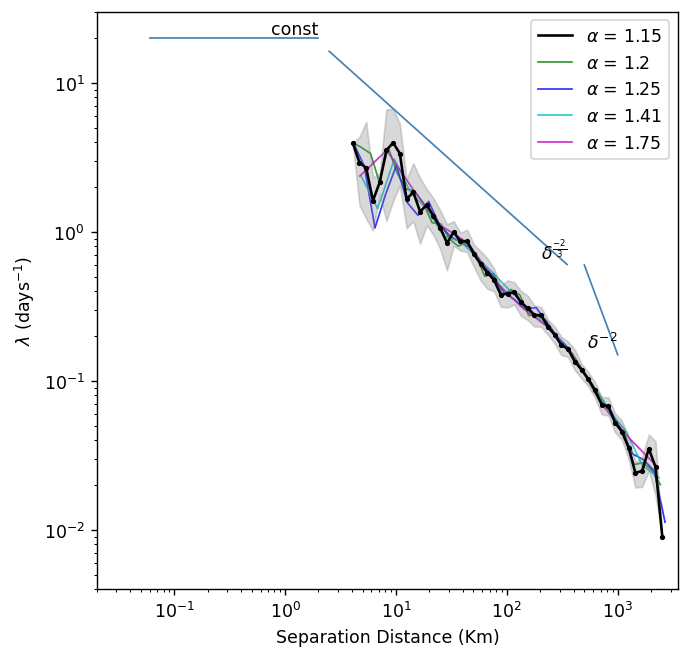

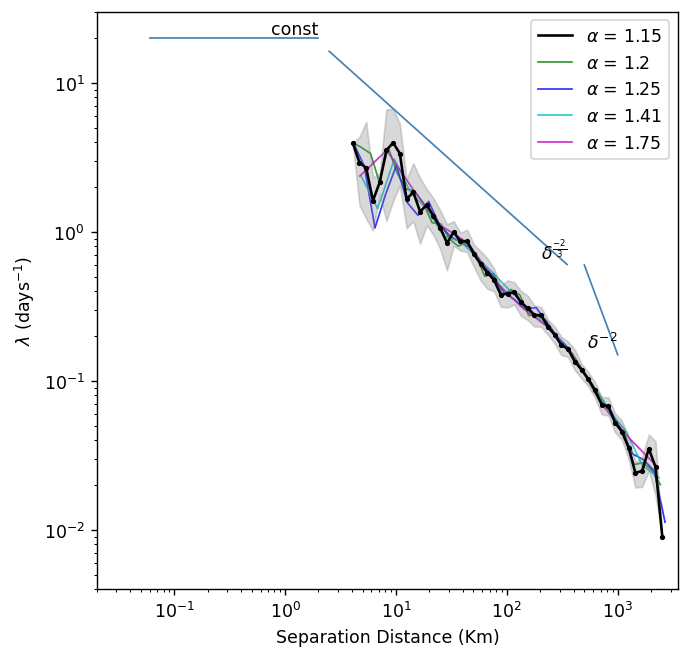

In [18]:

threshold_rates = [1.15, 1.2, 1.25, 1.41, 1.75] # List of alpha values for the FSLE (FSLE = ln(alpha)/delta(t))
#threshold_rates = [1.41] # Root 2
fsle_df_list = [] # Store all the fsle result dataframes

for rate in threshold_rates:
    fsle_tmp = ld.compute_fsle(df=EAC_DROGUE_FSLE, threshold_rate=rate)
    fsle_df_list.append(fsle_tmp)

fsle_plot = ld.plot_fsle_statistics(fsle_df_list, index=0)
fsle_plot

#for rate in threshold_rates:
#    fsle_tmp = ld.compute_fsle(df=EAC_UNDROGUE_FSLE, threshold_rate=rate)
#    fsle_df_list.append(fsle_tmp)
#
#fsle_plot = plot_fsle_statistics(fsle_df_list, index=0)
#fsle_plot

#for rate in threshold_rates:
#    fsle_tmp = ld.compute_fsle(df=SUMMER_DROGUE_PAIRS, threshold_rate=rate)
#    fsle_df_list.append(fsle_tmp)
#
#fsle_plot = plot_fsle_statistics(fsle_df_list, index=0)
#fsle_plot

#for rate in threshold_rates:
#    fsle_tmp = ld.compute_fsle(df=WINTER_DROGUE_PAIRS, threshold_rate=rate)
#    fsle_df_list.append(fsle_tmp)
#
#fsle_plot = plot_fsle_statistics(fsle_df_list, index=0)